### import packages and read available files

In [23]:
import pandas as pd

import pickle
import os
import numpy as np
import pandas as pd



file =  os.listdir('../../data/Comment_to_Elon/')
donefile = [f.split('.')[0]+'.csv' for f in os.listdir('../../data/ProcessedComment/')]
file = pd.DataFrame(set(file) - set(donefile))
file = file.drop(0)
file.head()

,0
1,to_Elon_2019-04_test.csv


In [24]:
len(file)
# file = file.drop(0)
# start standford server
# ! java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer 

# https://github.com/smilli/py-corenlp

1

## Prepare function for the sentimental analysis

In [25]:
def tokenize(text):
    """ create text by stemming
    
    Parameters:
        text: string
            text
            
    Returns: String
        
    """
    import nltk.tokenize as nt
    import nltk
    import pandas as pd 
    from nltk.stem.wordnet import WordNetLemmatizer
    from nltk.tokenize import RegexpTokenizer
    from nltk.stem import PorterStemmer
    import numpy as np
    from nltk.tokenize import sent_tokenize, word_tokenize
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_sent=tokenizer.tokenize('@ elonmusk congrats for next step. we will never stop untill every car in the road become electric" i love those words of ur mission'.lower())
    from nltk.corpus import stopwords
    stop_words = stopwords.words('english')
    
    stop_words = np.append(np.array(stop_words),np.array(['s','ll'])) # get stopword
    words = [w for w in tokenized_sent if not w in stop_words]
    ps = PorterStemmer()
    words = [ps.stem(w) for w in words]

    return(' '.join(words))

def sentimental(text):
    """ get sentimental score from Textblob lib
    
    Parameters:
        text: string
            text
            
    Returns: array
        [sentimentality, subjectivity]
        
    """
    import numpy as np
    from textblob import TextBlob
    from socket import error as SocketError
    import math
    from statistics import mean 
    if text != '':
#         print(text)
        try:

            blob = TextBlob(text)
        except SocketError as e:
            print(e)
            print(text)
            return [1000,1000]
        sen = []
        sub = []
        for sentence in blob.sentences:
            sen += [sentence.sentiment.polarity]
            sub += [sentence.sentiment.subjectivity]
        return [mean(sen),mean(sub)] 
    else:
        return [0,0]
        
def StandfordSentimental(text):
    
#     We ended up didn't use Stanford CoreNLP since the result is very negative prone. 
# We did a sentimental analysis from Stanford CoreNLP and Textblob together. It's turn out that Textblob is better
    import time
    from socket import error as SocketError
    time.sleep(1)
    from statistics import mean 
    from pycorenlp import StanfordCoreNLP
    import math
    if text != np.nan:
        try:
    #         print(text)
            nlp = StanfordCoreNLP('http://localhost:9000')
            res = nlp.annotate(text, properties={
                               'annotators': 'sentiment',
                               'outputFormat': 'json',
                               'timeout': 5000
                           })
            sentimental = []

            if (type(res) == str):
                print(res)
                print(text)
                return 1000
            for s in res["sentences"]:
                sentimental = sentimental + [int(s["sentimentValue"])]
                print(sentimental)
            return mean(sentimental)
        except SocketError as e:
            print(e)
            return(1000)
    else:
        return(1000)

In [27]:
# Each Comments file contains data from a certain month.
# loop through all comment from each month and find sentimental score


for i,f in file.iterrows():
    print('----------------------',f[0])
    month = int(f[0].split('-')[1].split('.')[0])
    
    
    dtype={0:'object',1:'object',2:'int64',3:'int64',4:'object',5:'object',6:'object',7:'object',8:'object',9:'object',
      10:'object',11:'object',12:'object',13:'object'}
    comment = pd.read_csv('../../data/Comment_to_Elon/'+f[0], sep=';', error_bad_lines=False,dtype=dtype)

    comment.date = pd.to_datetime(comment.date)
    comment=comment[[True if c.isreply else False for i,c in comment.iterrows()]]
    comment = comment[[i.month ==month for i in comment.date]]
    comment = comment.replace(np.nan, '', regex=True)
    c = [ sentimental(c.text) for j,c in comment.iterrows() if c.text != np.nan]
    comment['sentimental'] = [i[0] for i in c]
    comment['subjectivity'] = [i[1] for i in c]

    with open('../../data/ProcessedComment/'+f[0].split('.')[0]+'.pickle', 'wb') as handle:
        pickle.dump(comment, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [1]:
# import stanfordnlp
# from stanfordnlp.server import CoreNLPClient
# ! export CORENLP_HOME=~/prs/workspace/stanford-corenlp-full-2018-10-05
# text = 'Barack Obama was born in Hawaii.  He was elected president in 2008.'
# with CoreNLPClient(annotators=['tokenize','ssplit','pos','lemma','ner', 'parse', 'depparse','sentiment'], timeout=30000, memory='16G') as client:
#     # submit the request to the server
#     ann = client.annotate(text)

#     # get the first sentence
#     sentence = ann.sentence[0]
#     print(sentence)

# month = 4

# dtype={0:'object',1:'object',2:'int64',3:'int64',4:'object',5:'object',6:'object',7:'object',8:'object',9:'object',
#   10:'object',11:'object',12:'object',13:'object'}
# comment = pd.read_csv('../../data/Comment_to_Elon/'+file[0][1], sep=';', error_bad_lines=False,dtype=dtype)
# comment
# comment.date = pd.to_datetime(comment.date)
# comment=comment[[True if c.isreply else False for i,c in comment.iterrows()]]
# comment = comment[[i.month ==month for i in comment.date]]
# comment = comment.replace(np.nan, '', regex=True)
# c = [ sentimental(c.text) for j,c in comment.iterrows() if c.text != np.nan]
# comment['sentimental'] = [i[0] for i in c]
# comment['subjectivity'] = [i[1] for i in c]





# with open('../../data/ProcessedComment/'+file[0][1].split('.')[0]+'.pickle', 'wb') as handle:
#     pickle.dump(comment, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [55]:
commentfile = [f for f in os.listdir('../../data/ProcessedComment/')]
commentfile[1:10]
commentfile.remove('.ipynb_checkpoints')
file = open("../../data/ProcessedComment/" + commentfile[0],'rb')
obj = pickle.load(file,encoding='utf-8')

obj.head()

,username,date,retweets,favorites,text,geo,mentions,hashtags,id,permalink,emoji,isreply,replyto,origin,sentimental,subjectivity
0,,2017-02-28 23:59:00,0,0,"don't fly away,calm down",,,,836727495604977664,https://twitter.com/mu2ng/status/8367274956049...,🤡,True,elonmusk,836328719165763584,0.322222,0.594444
1,,2017-02-28 23:53:00,0,0,@ MKBHD @ SpaceX and let me play among the stars,,@ @,,836725943980929024,https://twitter.com/Mayerofthebeats/status/836...,,True,elonmusk,836328719165763584,0.000000,0.000000
2,,2017-02-28 23:51:00,0,0,@ elonmusk Please buy their patent. At least 4...,,@,,836725642053943296,https://twitter.com/AmritKarki17/status/836725...,,False,,836725642053943296,-0.100000,0.133333
3,,2017-02-28 23:51:00,0,0,@ elonmusk @ SpaceX when do you hope to attemp...,,@ @,,836725585237921793,https://twitter.com/logangroover/status/836725...,,False,,836725585237921793,0.000000,0.000000
4,,2017-02-28 23:50:00,0,0,"Love the technology but waste of time, $ and r...",,,,836725297680633856,https://twitter.com/brooklynrichied/status/836...,,True,elonmusk,836328719165763584,0.400000,0.450000


In [ ]:
# Group comments from the same hours
# count the numbers of comments, sum the sentimental score of each comment, find average score and find percentage of positive/ negative comments


for i in commentfile:
    print(i)
    file = open("../../data/ProcessedComment/" + i,'rb')
    obj = pickle.load(file,encoding='utf-8')
    obj = obj.drop(['isreply','replyto','origin','id','username'],axis=1)
    obj['hour'] = obj.date.apply(lambda x: x.hour)
    obj['day'] = obj.date.apply(lambda x: x.day)
    obj['month'] = obj.date.apply(lambda x: x.month)
    obj['year'] = obj.date.apply(lambda x: x.year)
    obj['hourly'] = pd.to_datetime(obj[['year', 'month', 'day', 'hour']])
    group = obj.groupby('hourly').sum().astype(int)
    group['countComment'] = obj.groupby('hourly').apply(lambda x: len(x)).astype(int)
    group['posCommentAmount'] = obj.groupby('hourly').apply(lambda x: (x.sentimental>0).sum()).astype(int)
    group['negCommentAmount'] = obj.groupby('hourly').apply(lambda x: (x.sentimental<0).sum()).astype(int)
    group['neuCommentAmount'] = obj.groupby('hourly').apply(lambda x: (x.sentimental==0).sum()).astype(int)
    group['posCommentSum'] = obj.groupby('hourly').apply(lambda x: sum([y for y in x['sentimental'] if y>0 ]))
    group['negCommentSum'] = obj.groupby('hourly').apply(lambda x: sum([y for y in x['sentimental'] if y<0 ]))
    group['neuCommentSum'] = obj.groupby('hourly').apply(lambda x: sum([y for y in x['sentimental'] if y==0 ]))
    import matplotlib.pyplot as plt
    group['retweets/10000'] = pd.to_numeric(group['retweets']/10000)
    group['favorites/10000'] = pd.to_numeric(group['favorites']/10000)
    group['retweets'] = group['retweets'].astype(int)
    group['favorites'] = group['favorites'].astype(int)
    plt.figure()
    group.plot(
        y=group.columns.drop(['hour', 'day','month', 'year','retweets','favorites']),  
        figsize=(30, 10)).set_title(i, fontsize=20)
    plt.savefig('../../data/HourlyImageOfComment/'+ i.split('.')[0]+'.jpg')
    plt.clf()
    plt.close('all')
    path= '../../data/features/2019_04_21_picklehourlycomments_Pa.hdf5'
    import h5py
#     print(group.drop(['year','month','day','hour'],axis=1).dtypes)
    pd.set_option('io.hdf.default.format', 'table')
    group.drop(['year','month','day','hour'],axis=1).to_hdf(path,mode='a',index = False,key='table', format='table', header = (not os.path.exists(path)), append = True) 



In [ ]:
# How to open

f = pd.read_hdf(path,key='table')

f.countComment.plot()
plt.show()

## Match Elon's tweets with comments

In [2]:
import pandas as pd

dtype={0:'object',1:'object',2:'int64',3:'int64',4:'object',5:'object',6:'object',7:'object',8:'object',9:'object',
      10:'object',11:'object',12:'object',13:'object'}
Elon = pd.read_csv('../../data/Elon.csv', sep=';', error_bad_lines=False,dtype=dtype)
Elon.date = pd.to_datetime(Elon.date)
Elon = Elon.drop(['geo','mentions','hashtags'],axis=1)
Elon['month'] = Elon.date.apply(lambda x: x.month)
Elon['year'] = Elon.date.apply(lambda x: x.year)
Elon = Elon.fillna('')
Elon['origin'] = [e.id if e.origin == ''   else e.origin for _,e in Elon.iterrows()]

Elon = Elon[(Elon.year == 2018) & (Elon.month==4)]
Elon

In [58]:
# Matched comments with original Tweets then generates features by 
# count the numbers of comments, sum the sentimental score of each comment, find average score and find percentage of positive/ negative comments


def featureGenerate(x,i,window):
    import pickle
    import numpy as np
    import os
    import statistics as st
    m = x.month
    y = x.year
    d = x.date.day
    exists = os.path.isfile("../../data/ProcessedComment/to_Elon_%s-%02d.pickle" % (y,m))
    if exists:
        file1 = open("../../data/ProcessedComment/to_Elon_%s-%02d.pickle" % (y,m) ,'rb')
        data = pickle.load(file1,encoding='utf-8')
       
        
        
        if (m!=4 and y != 2019) and (d >= 30):
            file2 = open("../../data/ProcessedComment/to_Elon_%s-%02d.pickle" % (y if (m+1)//12 == 0 else  y+1,(m+1)%12+1) ,'rb')
            obj2 = pickle.load(file2,encoding='utf-8')
            data = data.append(obj2)
        data = data[data.origin != '']
        data.origin = data.origin.astype(np.int64).astype(str)
        data = data.drop(['isreply','replyto','id','username','permalink','geo','hashtags','mentions','text' ],axis=1)
        import datetime as datetime
        from datetime import datetime, timedelta
        
#         match only comments that were posted no longer than 1 hour after Elon had tweeted
        com = data[[d.date.replace(tzinfo=None) <= Elon.date.loc[i].replace(tzinfo=None) + timedelta(hours=window) and Elon.origin.loc[i] == d.origin for _,d in data.iterrows()]]
        if len(com) == 0:
            group = pd.DataFrame({'retweets':0,'favorites': 0,'sentimental': 0.0,'subjectivity': 0.0,'date':Elon.date.loc[i],'id': Elon.id.loc[i],'origin': Elon.origin.loc[i],'countComment': 0,'posCommentAmount': 0,'negCommentAmount': 0,'neuCommentAmount': 0,'posCommentSum': 0.0,'negCommentSum': 0.0,'CommentSD': 0.0,'posCommentSD': 0.0,'negCommentSD': 0.0} , index=[0])
        else:    
            
            group = pd.DataFrame(com.sum()).T
#             print(group)
            group['sentimental'] = float(group['sentimental'])
            group['subjectivity'] = float(group['subjectivity'])
    
            group['date'] = Elon.date.loc[i]
            group['id'] = Elon.id.loc[i]
            group['origin'] = Elon.origin.loc[i]
#             group['emoji'] = com.emoji.sum()
            group['countComment'] = len(com)
            group['posCommentAmount'] = int(sum([ x.sentimental>0 for _,x in com.iterrows()]))
            group['negCommentAmount'] = int(sum([ x.sentimental<0 for _,x in com.iterrows()]))
            group['neuCommentAmount'] = int(sum([ x.sentimental==0 for _,x in com.iterrows()]))
            group['posCommentSum'] = float(sum([ x.sentimental for _,x in com.iterrows() if x.sentimental>0 ]))
            group['negCommentSum'] = float(sum([x.sentimental for _,x in com.iterrows() if x.sentimental<0]))
            group['CommentSD'] = st.stdev([ x.sentimental for _,x in com.iterrows()]) if group['countComment'].iloc[0] > 1 else 0.0
            group['posCommentSD'] = st.stdev([ x.sentimental for _,x in com.iterrows() if x.sentimental>0 ]) if group['posCommentAmount'].iloc[0] > 1 else 0.0 
            group['negCommentSD'] = st.stdev([ x.sentimental for _,x in com.iterrows() if x.sentimental<0 ]) if group['negCommentAmount'].iloc[0] > 1 else 0.0
            group['retweets'] = group['retweets'].astype(int)
            group['favorites'] = group['favorites'].astype(int)
            group['negPercent'] = group.negCommentAmount.iloc[0]/group.countComment.iloc[0]
            group['posPercent'] = group.posCommentAmount.iloc[0]/group.countComment.iloc[0]

#         print(group.dtypes)
        import h5py
#     print(group.drop(['year','month','day','hour'],axis=1).dtypes)
        path= '../../data/features/2019_04_30_Eloncomments'+str(window)+'hour_fix2018-04_Pa.hdf5'
        pd.set_option('io.hdf.default.format', 'table')
        group = group[['retweets', 'favorites', 'sentimental', 'subjectivity', 'date', 'id',
       'origin', 'countComment', 'posCommentAmount', 'negCommentAmount',
       'neuCommentAmount', 'posCommentSum', 'negCommentSum', 'CommentSD',
       'posCommentSD', 'negCommentSD']]
        pd.DataFrame(group).to_hdf(path,mode='a',index = False,key='table', format='table', header = (not os.path.exists(path)), append = True) 
        print(i,m,y,group['countComment'])

# comfeature = Elon.groupby(['year','month']).apply(lambda x: featureGenerate(x))
import os
comfeature = [featureGenerate(e,i,1) for i,e in Elon.iterrows() if os.path.isfile("../../data/ProcessedComment/to_Elon_%s-%02d.pickle" % (e.year,e.month))]

2781 4 2018 0    879
Name: countComment, dtype: int64
2782 4 2018 0    439
Name: countComment, dtype: int64
2783 4 2018 0    302
Name: countComment, dtype: int64
2784 4 2018 0    295
Name: countComment, dtype: int64
2785 4 2018 0    151
Name: countComment, dtype: int64
2786 4 2018 0    142
Name: countComment, dtype: int64
2787 4 2018 0    139
Name: countComment, dtype: int64
2788 4 2018 0    2829
Name: countComment, dtype: int64
2789 4 2018 0    2751
Name: countComment, dtype: int64
2790 4 2018 0    100
Name: countComment, dtype: int64
2791 4 2018 0    41
Name: countComment, dtype: int64
2792 4 2018 0    0
Name: countComment, dtype: int64
2793 4 2018 0    0
Name: countComment, dtype: int64
2794 4 2018 0    0
Name: countComment, dtype: int64
2795 4 2018 0    0
Name: countComment, dtype: int64
2796 4 2018 0    0
Name: countComment, dtype: int64
2797 4 2018 0    0
Name: countComment, dtype: int64
2798 4 2018 0    0
Name: countComment, dtype: int64
2799 4 2018 0    0
Name: countComment, dt

In [57]:
import h5py
import pandas as pd
path= '../../data/features/2019_04_30_Eloncomments1hour_Pa.hdf5'
f = pd.read_hdf(path,key='table')

Elon['month'] = Elon.date.apply(lambda x: x.month)
Elon['year'] = Elon.date.apply(lambda x: x.year)
Elon = Elon.fillna('')
Elon['origin'] = [e.id if e.origin == ''   else e.origin for _,e in Elon.iterrows()]

Elon = Elon[(Elon.year == 2018) & (Elon.month==4)]


# from joblib import Parallel, delayed
# Parallel(n_jobs=3)(delayed(featureGenerate)(e,i,1) for i,e in Elon.iterrows() if os.path.isfile("../../data/ProcessedComment/to_Elon_%s-%02d.pickle" % (e.year,e.month)))

FileNotFoundError: File ../../data/features/2019_04_30_Eloncomments1hour_Pa.hdf5 does not exist

In [1]:
# def featureGenerate(x,i,windows):
#     import statistics as st
#     m = x.month.iloc[0]
#     y = x.year.iloc[0]
# #     print(m,y)
#     exists = os.path.isfile("../../data/ProcessedComment/to_Elon_%s-%02d.pickle" % (y,m))
#     if exists:
#         file1 = open("../../data/ProcessedComment/to_Elon_%s-%02d.pickle" % (y,m) ,'rb')
#         data = pickle.load(file1,encoding='utf-8')
#         data = data.drop(['isreply','replyto','id','username','permalink','isreply','replyto','geo'],axis=1)
#         data = data[data.origin != '']
#         data.origin = data.origin.astype(np.int64).astype(str)
#         if m!=4 and y != 2019:
#             file2 = open("../../data/ProcessedComment/to_Elon_%s-%02d.pickle" % (y if (m+1)//12 == 0 else  y+1,(m+1)%12) ,'rb')
#             obj2 = pickle.load(file2,encoding='utf-8')
#             data = data.append(obj2)
#         import datetime as datetime
#         from datetime import datetime, timedelta
#         com = data[[d.date.replace(tzinfo=None) <= Elon.date.iloc[i].replace(tzinfo=None) + timedelta(hours=window) and Elon.id.iloc[i] == d.origin for _,d in data.iterrows()]]

#         group = pd.DataFrame(com.sum()).T
        
#         group['countComment'] = len(com)
#         group['posCommentAmount'] = int(sum([ x.sentimental>0 for _,x in com.iterrows()]))
#         group['negCommentAmount'] = int(sum([ x.sentimental<0 for _,x in com.iterrows()]))
#         group['neuCommentAmount'] = int(sum([ x.sentimental==0 for _,x in com.iterrows()]))
#         group['posCommentSum'] = int(sum([ x.sentimental for _,x in com.iterrows() if x.sentimental>0 ]))
#         group['negCommentSum'] = int(sum([x.sentimental for _,x in com.iterrows() if x.sentimental<0]))
#         # group['posCommentSum'] = obj.groupby('hourly').apply(lambda x: sum([y for y in x['sentimental'] if y>0 ]))
#         # group['negCommentSum'] = obj.groupby('hourly').apply(lambda x: sum([y for y in x['sentimental'] if y<0 ]))
#         # group['neuCommentSum'] = obj.groupby('hourly').apply(lambda x: sum([y for y in x['sentimental'] if y==0 ]))
#         # import matplotlib.pyplot as plt
#         # group['retweets/10000'] = pd.to_numeric(group['retweets']/10000)
#         # group['favorites/10000'] = pd.to_numeric(group['favorites']/10000)
#         group['retweets'] = group['retweets'].astype(int)
#         group['favorites'] = group['favorites'].astype(int)
#         return group

# comfeature = Elon.groupby(['year','month']).apply(lambda x: featureGenerate(x))

# # comfeature = [featureGenerate(e,i,1) for i,e in Elon.iterrows() if os.path.isfile("../../data/ProcessedComment/to_Elon_%s-%02d.pickle" % (e.year,e.month))]

In [5]:
# Try open the file
import h5py
import pandas as pd
path= '../../data/features/2019_04_21_Eloncomments1hour_Pa.hdf5'
f = pd.read_hdf(path,key='table')
f['negPercent'] = f.negCommentAmount/f.countComment
f['posPercent'] = f.posCommentAmount/f.countComment
f.head()

,retweets,favorites,sentimental,subjectivity,date,id,origin,countComment,posCommentAmount,negCommentAmount,neuCommentAmount,posCommentSum,negCommentSum,CommentSD,posCommentSD,negCommentSD,negPercent,posPercent
0,10513,120734,63.134057,229.326642,2019-04-14 23:31:00,1117571159195668480,1117563679099240449,1379,286,122,971,93.863996,-30.729939,0.205439,0.245963,0.208518,0.088470,0.207397
0,10513,120734,63.134057,229.326642,2019-04-14 23:10:00,1117565769829818368,1117563679099240449,1379,286,122,971,93.863996,-30.729939,0.205439,0.245963,0.208518,0.088470,0.207397
0,10513,120734,63.134057,229.326642,2019-04-14 23:06:00,1117564774190075904,1117563679099240449,1379,286,122,971,93.863996,-30.729939,0.205439,0.245963,0.208518,0.088470,0.207397
0,10513,120734,63.134057,229.326642,2019-04-14 23:02:00,1117563769159286784,1117563679099240449,1379,286,122,971,93.863996,-30.729939,0.205439,0.245963,0.208518,0.088470,0.207397
0,373,19413,30.295510,123.411165,2019-04-14 22:54:00,1117561885040283648,1117553530615648256,727,153,74,500,50.753336,-20.457826,0.211838,0.228215,0.216880,0.101788,0.210454


/jet/var/python/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


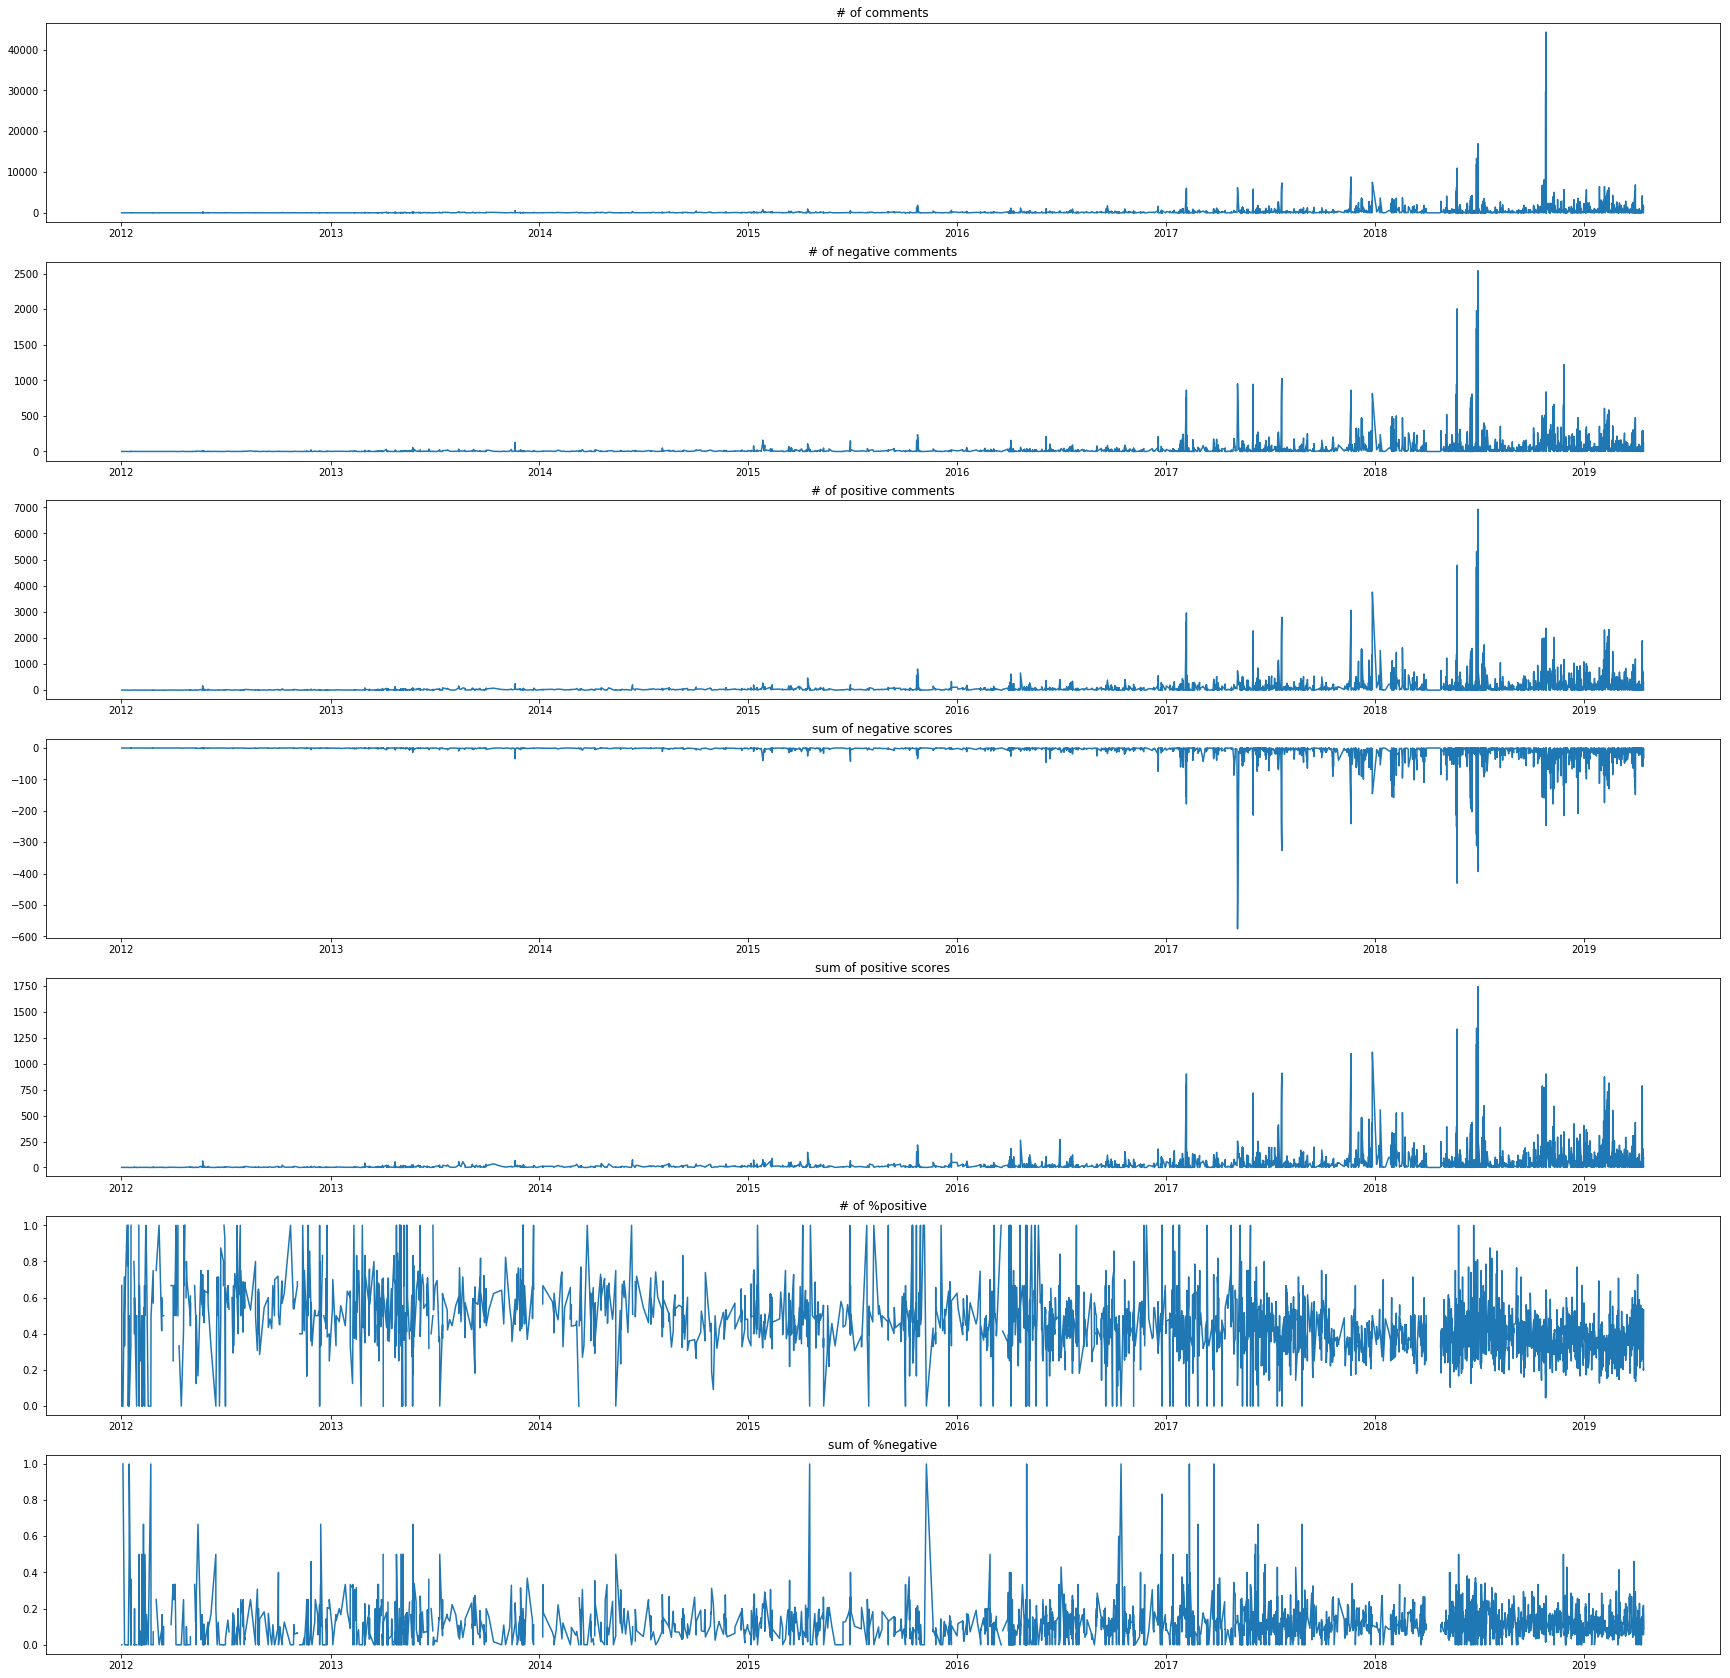

In [8]:
#  Analyze comments features!

import matplotlib.pyplot as plt
plt.figure(figsize=(30, 30))

plt.subplot(7, 1, 1)
plt.title('# of comments')
plt.plot(f.date, f.countComment)
plt.subplot(7, 1, 2)
plt.title('# of negative comments')
plt.plot(f.date, f.negCommentAmount)
plt.subplot(7, 1, 3)
plt.title('# of positive comments')
plt.plot(f.date, f.posCommentAmount)
plt.subplot(7, 1, 4)
plt.title('sum of negative scores')
plt.plot(f.date, f.negCommentSum)
plt.subplot(7, 1, 5)
plt.title('sum of positive scores')
plt.plot(f.date, f.posCommentSum)
plt.subplot(7, 1, 6)
plt.title('# of %positive')
plt.plot(f.date, f.posPercent)
plt.subplot(7, 1, 7)
plt.title('sum of %negative')
plt.plot(f.date, f.negPercent)
plt.show()



In [7]:
path= '../../data/features/2019_04_29_picklehourlycomments_Pa.hdf5'
import h5py

pd.set_option('io.hdf.default.format', 'table')
f.to_hdf(path,mode='a',index = False,key='table', format='table', header = (not os.path.exists(path)), append = True) 

